In [173]:
import numpy as np
import pandas as pd

from importlib import reload

import synthetic.render.generator as gen

import matplotlib.pyplot as plt
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import images

In [184]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'
data = fio.read(catalog_path)
catalog_cluster = data[data['LOC'] == 1]
catalog_field = data[data['LOC'] == 0]

In [188]:
catalog = np.hstack((catalog_cluster, catalog_field))

In [189]:
catalog = catalog[catalog["MAG_I"] > 24]

In [190]:
# catalog["G1"] = 0.05
# catalog["G2"] = -0.02

In [191]:
df = render.DrawField(5000, catalog, band="i")

In [192]:
df.prepare()
df.make_infodicts()
df.multi_render(100)
df.collate_stamps()

starting xshear calculations in 100 processes


In [193]:
# galpath = "./ICL/evolving_red_gal.dat"
# mstarpath = "./ICL/mstar_des_i03.fit"
# jk_profile_root = "./ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

# bcg = {
#     "size": 32.,
#     "g1": 0.1356766444194723,
#     "g2":-0.0345231539560347,
#     "imag": 17.76,
#     "color_gr": 1.36,
#     "color_ri": 0.54,
#     "color_iz": 0.32,
# }
# mass = 10**14.45
# z = 0.3

# di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)
# di.get_icl()
# icl_arrs = [di.flux_g, di.flux_r, di.flux_i, di.flux_z]

In [194]:
noise_std = 8.36335 / 10
noise = np.random.normal(scale=noise_std, size=(5000, 5000))


Text(0, 0.5, 'Y [pix]')

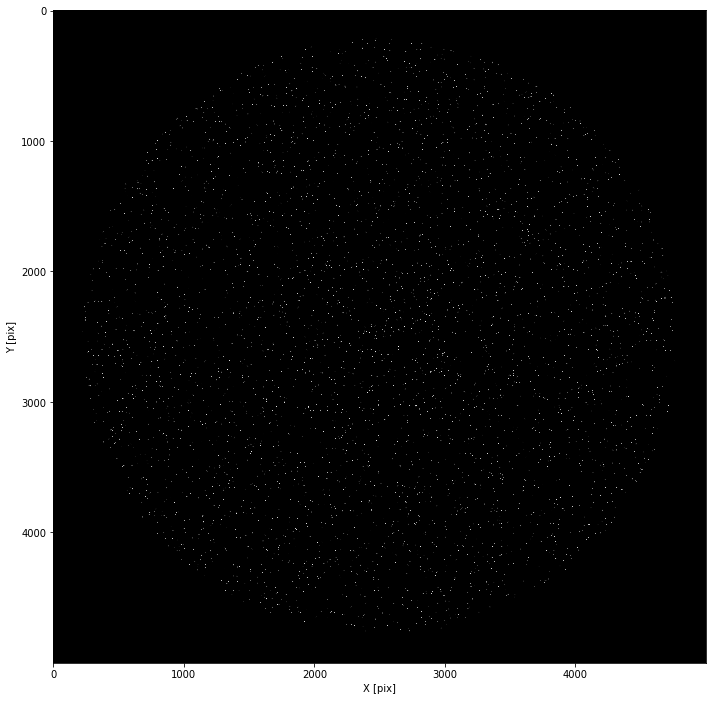

In [195]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array + 0.001
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

In [201]:
noise_std = 8.36335 
noise = np.random.normal(scale=noise_std, size=(5000, 5000))


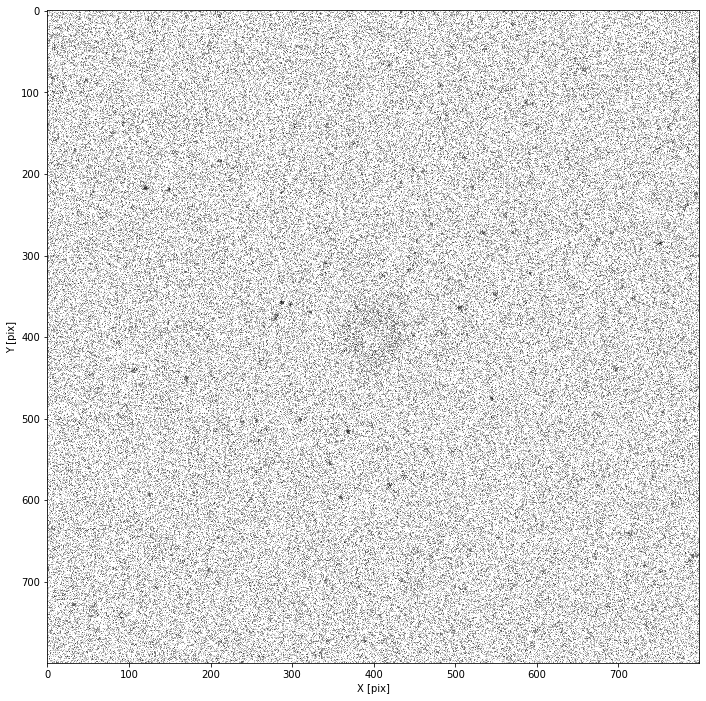

In [203]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
#cc = icl_arrs[2]
cc = df.canvas.array + noise + icl_arrs[2]
cc = cc[2100:2900, 2100:2900]
ax.imshow(images.asinh_scale(cc*0.01, 0.12) * 2, cmap=plt.cm.gray_r)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("iband_grayscale.png")

# Estimating shear in the image

In [ ]:
class ExtractShear(object):
    def __init__(self, drawer):
        self.drawer = drawer
        self.raw_stamps = self.drawer.stamps
        self.image_epsf = self.drawer.image_epsf
        self.BADVAL = -9999
        
    def extract_stamps(self, size=32):
        self.stamps = []
        
        half_size = size // 2
        
        for i, stamp in enumerate(self.raw_stamps):
            bounds = stamp.bounds
            cen = bounds.center
            bb = galsim.bounds.BoundsI(cen.x - half_size,
                                       cen.x + half_size - 1,
                                       cen.y - half_size,
                                       cen.y + half_size - 1)
            self.stamps.append(self.drawer.canvas[bb])
    
    def estimate_shear(self, sky_var=0, shear_est="KSB", which="canvas"):
        """
        shear modes = REGAUSS’, ‘LINEAR’, ‘BJ’, or ‘KSB’
        which is raw or canvas, default to canvas
        """
        
        stamps = self.raw_stamps
        if which == "canvas":
            stamps = self.stamps
        
        self.logs = []
        self.shears = []
        self.success = []
        self.fluxes = []
        self.shears_error = []
        for i, im in enumerate(stamps):
            try:
                res = galsim.hsm.EstimateShear(im, self.image_epsf, shear_est=shear_est, sky_var=sky_var)
                self.logs.append(res)
                
                tmp = np.array([res.corrected_g1, res.corrected_g2])
                
                self.shears.append(tmp)
                self.fluxes.append(res.moments_amp * (self.drawer.pixel_scale)**2)
                self.shears_error.append(res.corrected_shape_err)
                self.success.append(True)
#                 print("here")
            except:
                self.logs.append(None)
                self.fluxes.append(None)
                tmp = np.array([self.BADVAL, self.BADVAL])
                self.shears.append(tmp)
                self.shears_error.append(None)
                self.success.append(False)
                
                
               
        self.fluxes = np.array(self.fluxes)
        self.shears = np.array(self.shears)
        self.success = np.array(self.success)
        self.shears_error = np.array(self.shears_error)
        

In [144]:
df.add_icl(noise)

In [145]:
noise_var = noise_std**2

In [146]:
es = ExtractShear(df)
es.extract_stamps()
es.estimate_shear(sky_var=noise_var, shear_est="KSB")

In [151]:
np.average(es.shears[es.success, 0])


0.04197182903103211

In [152]:
np.average(es.shears[es.success, 1])

-0.07193463670679008

Text(0, 0.5, 'G2')

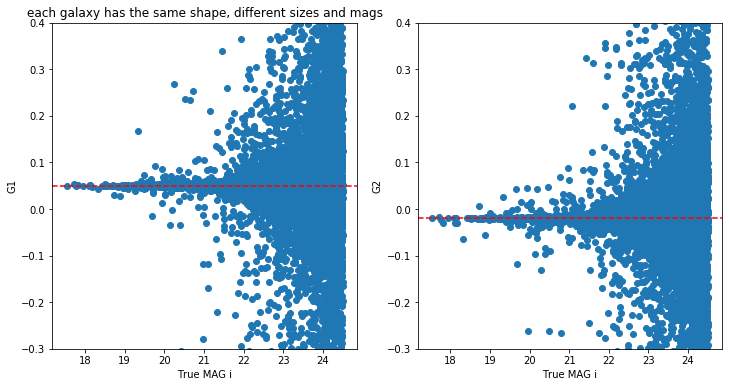

In [162]:
fig, axarr = plt.subplots(ncols=2, figsize=(12, 6))

ax = axarr[0]
ax.set_title("each galaxy has the same shape, different sizes and mags")
val1 = catalog["MAG_I"][es.success]
val2 = es.shears[es.success, 0]
ax.scatter(val1, val2)
# ax.set_yscale("log")
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel("True MAG i")
ax.axhline(0.05, color="red", ls="--")
ax.set_ylabel("G1")

ax = axarr[1]
val1 = catalog["MAG_I"][es.success]
val2 = es.shears[es.success, 1]
ax.scatter(val1, val2)
# ax.set_yscale("log")
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel("True MAG i")
ax.axhline(-0.02, color="red", ls="--")
ax.set_ylabel("G2")




In [164]:
es2 = ExtractShear(df)
es2.extract_stamps(size=32)
es2.estimate_shear(sky_var=noise_var, shear_est="KSB", which="raw")

Text(0, 0.5, 'G2')

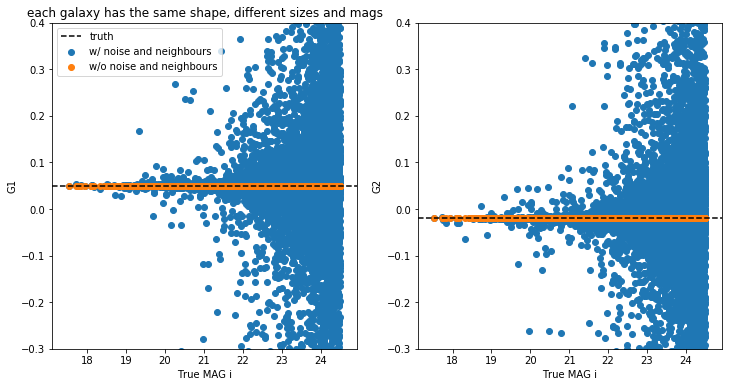

In [171]:
fig, axarr = plt.subplots(ncols=2, figsize=(12, 6))

ax = axarr[0]
ax.set_title("each galaxy has the same shape, different sizes and mags")
val1 = catalog["MAG_I"][es.success]
val2 = es.shears[es.success, 0]
val3 = es2.shears[es2.success, 0]
ax.scatter(val1, val2, label="w/ noise and neighbours")
ax.scatter(catalog["MAG_I"][es2.success], val3, label="w/o noise and neighbours")
# ax.set_yscale("log")
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel("True MAG i")
ax.axhline(0.05, color="black", ls="--", label="truth")
ax.set_ylabel("G1")
ax.legend()

ax = axarr[1]
val1 = catalog["MAG_I"][es.success]
val2 = es.shears[es.success, 1]
ax.scatter(val1, val2)
val3 = es2.shears[es2.success, 1]
ax.scatter(catalog["MAG_I"][es2.success], val3)

# ax.set_yscale("log")
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel("True MAG i")
ax.axhline(-0.02, color="black", ls="--")
ax.set_ylabel("G2")


In [172]:
np.average(es.shears[flag, 0], weights=1 / es.shears_error[flag])

TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

In [97]:
es.shears_error[flag].mean()

0.04449300202374424

In [98]:
np.average(np.abs(es.shears[flag, 0]), weights=es.shears_error[flag])

0.15357325146273773

In [50]:
np.average(np.abs(es.shears[flag, 1] - catalog["G2"][flag]), weights=es.shears_error[flag])

0.20856628318365186

AttributeError: 'float' object has no attribute 'sqrt'

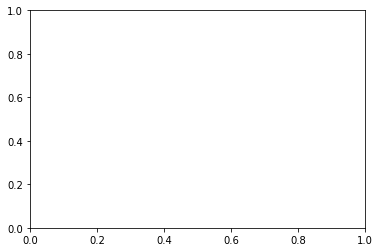

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

val1 = catalog["MAG_I"][es.success]
val2 = np.abs(es.shears[es.success, 0] - catalog["G1"][es.success])
ax.scatter(val1, val2, s=es.shears_error[es.success])
ax.set_ylim(0.0004, 4)
ax.set_yscale("log")
ax.axhline(0.05, color="red")
# ax.set_xlabel("True MAG i")
# ax.set_ylabel("$\delta$ MAG (measured - true) / true")